## Importing Python libraries

In [2]:
import numpy as np
import mpctools as mpc
import mpctools.plots as mpcplots
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import control as ctrl
import optuna
import time

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Defining the continous and discrete state space representations

In [3]:
# Define continuous time model.
Acont = np.array([[-1.2822, 0, 0.98, 0],
              [0, 0, 1, 0],
              [-5.4293, 0, -1.8366, 0],
              [-128.2, 128.2, 0, 0]])
Bcont = np.array([[-0.3], [0], [-17], [0]])
Ccont = np.array([[0, 1, 0, 0], [0, 0, 1, 0]])
Dcont = np.array([[0], [0]])

n = Acont.shape[0] # Number of states.
m = Bcont.shape[1] # Number of control elements

# Discretize.
dt = .25
Nt = 10 # Pas de temps
(A, B) = mpc.util.c2d(Acont,Bcont,dt)

def ffunc(x,u):
    """Linear discrete-time model."""
    return mpc.mtimes(A, x) + mpc.mtimes(B, u)
f = mpc.getCasadiFunc(ffunc, [n, m], ["x", "u"], "f")

## Defining MPC parameters

In [4]:
# Bounds on u, du, and x.
umax = 0.262
umin = -0.262
dumax = 0.524
dumin = -0.524
x2max = 0.349
x2min = -0.349

x_min = [-np.inf, x2min, -np.inf, -np.inf]
x_max = [np.inf, x2max, np.inf, np.inf]

lb = dict(u=[umin], du=[dumin], x=x_min)
ub = dict(u=[umax], du=[dumax], x=x_max)

# Define Q and R matrices.
Q = np.diag([1, 1, 1, 1])
R = np.array([[100]])

def lfunc(x,u):
    """Quadratic stage cost."""
    return mpc.mtimes(x.T, Q, x) + mpc.mtimes(u.T, R, u)

l = mpc.getCasadiFunc(lfunc, [n,m], ["x","u"], "l")

# Initial condition and sizes.
x0 = np.array([0,0, 0, 100])
N = {"x" : n, "u" : m, "t" : Nt}


## Solving MPC

In [5]:
# Solve MPC
solver = mpc.nmpc(f, l, N, x0, lb, ub,verbosity=0, isQP=True)
nsim = 40
t = np.arange(nsim + 1) * dt
xcl = np.zeros((n, nsim + 1))
xcl[:, 0] = x0
ucl = np.zeros((m, nsim))
ducl = np.zeros((m, nsim))
x2cl = np.zeros(nsim + 1)
for k in range(nsim):
    solver.fixvar("x", 0, x0)
    sol = mpc.callSolver(solver)
    print("Iteration %d Status: %s" % (k, sol["status"]))
    xcl[:, k] = x0
    x2cl[k] = x0[1]  
    ucl[:, k] = sol["u"][0, :]    
    if k > 0:
        ducl[:, k] = ucl[:, k] - ucl[:, k - 1]
    else:
        ducl[:, k] = ucl[:, k] - 0
    x0 = ffunc(x0, ucl[:, k])
xcl[:, nsim] = x0
x2cl[nsim] = x0[1]



qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

Iteration 0 Status: Successful return.
I

## Plot closed-loop response

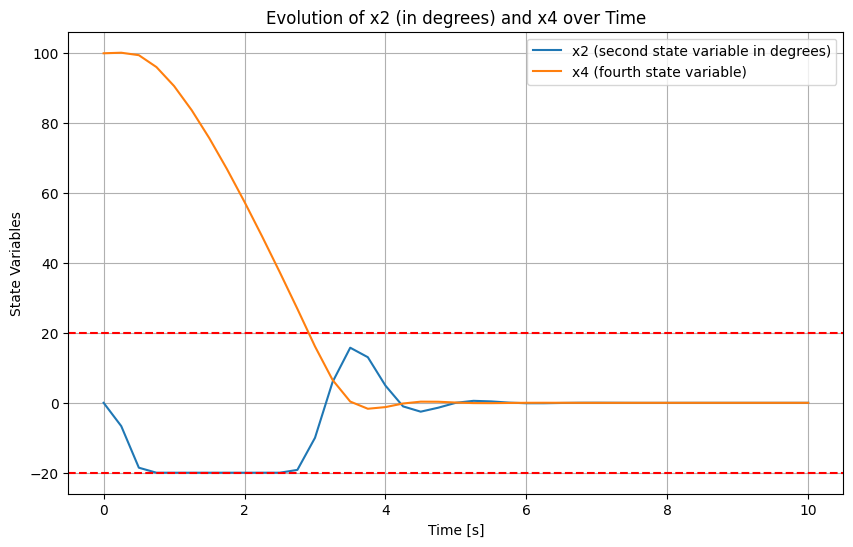

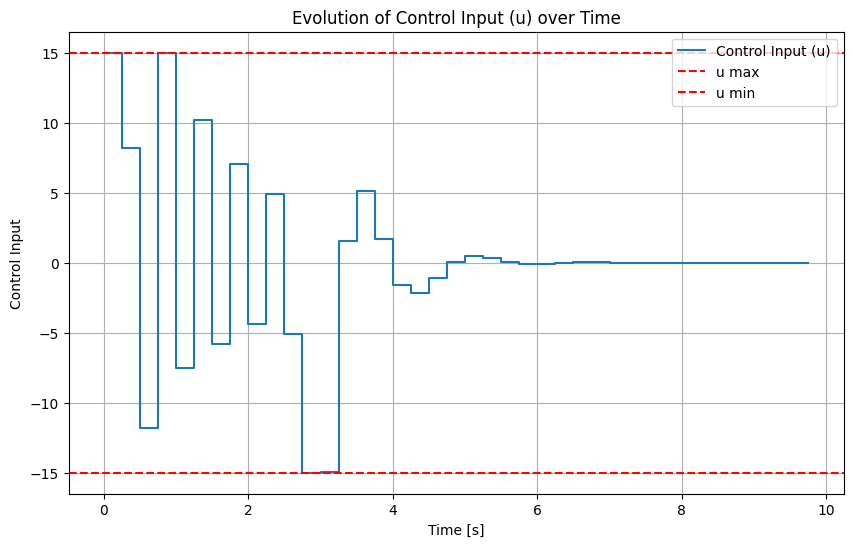

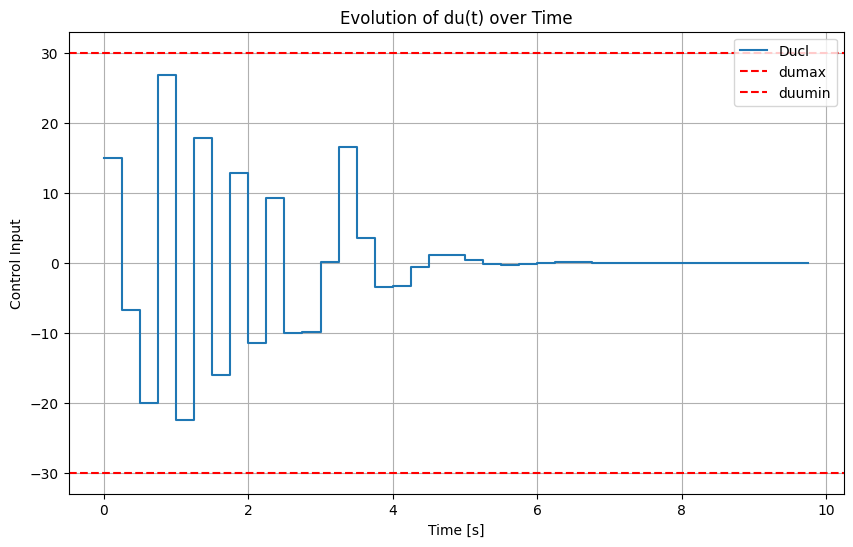

In [6]:
# Convert x2 from radians to degrees
x2_degrees = np.degrees(xcl[1, :])
x2max_degrees = np.degrees(x2max)
x2min_degrees = np.degrees(x2min)

# Plotting x2 and x4 
plt.figure(figsize=(10, 6))
plt.plot(t, x2_degrees, label='x2 (second state variable in degrees)')
plt.plot(t, xcl[3, :], label='x4 (fourth state variable)')
plt.axhline(x2max_degrees, color='r', linestyle='--')
plt.axhline(x2min_degrees, color='r', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('State Variables')
plt.title('Evolution of x2 (in degrees) and x4 over Time')
plt.legend()
plt.grid()
plt.show()

umax_degrees = np.degrees(umax)
umin_degrees = np.degrees(umin)
ucl_degrees = np.degrees(ucl)

# Plotting ucl
plt.figure(figsize=(10, 6))
plt.step(t[:-1], ucl_degrees.flatten(), where='post', label='Control Input (u)')  
plt.axhline(umax_degrees, color='r', linestyle='--', label='u max')
plt.axhline(umin_degrees, color='r', linestyle='--', label='u min')
plt.xlabel('Time [s]')
plt.ylabel('Control Input')
plt.title('Evolution of Control Input (u) over Time')
plt.legend()
plt.grid()
plt.show()

ducl_degrees = np.degrees(ducl)
dumax_degrees = np.degrees(dumax)
dumin_degrees = np.degrees(dumin)

# Plotting ducl 
plt.figure(figsize=(10, 6))
plt.step(t[:-1], ducl_degrees.flatten(), where='post', label='Ducl')  
plt.axhline(dumax_degrees, color='r', linestyle='--', label='dumax')
plt.axhline(dumin_degrees, color='r', linestyle='--', label='duumin')
plt.xlabel('Time [s]')
plt.ylabel('Control Input')
plt.title('Evolution of du(t) over Time')
plt.legend()
plt.grid()
plt.show()

## Monte-Carlo simulation

In [7]:
# Number of Monte Carlo simulations
num_simulations = 1000  

# Define ranges for initial conditions x1, x2, x3, x4
x1_range = [-0.2618, 0.2618]
x2_range = [-0.349, 0.349]  
x3_range = [-0.5, 0.5]
x4_range = [100, 100]

# Generate random initial conditions within the specified ranges
np.random.seed(42)  
x0_samples = np.zeros((num_simulations, n))
x0_samples[:, 0] = np.random.uniform(x1_range[0], x1_range[1], num_simulations)
x0_samples[:, 1] = np.random.uniform(x2_range[0], x2_range[1], num_simulations)
x0_samples[:, 2] = np.random.uniform(x3_range[0], x3_range[1], num_simulations)
x0_samples[:, 3] = np.random.uniform(x4_range[0], x4_range[1], num_simulations)

# Array to  store the computation time
MPC_per_iteration_times = []




## Simulating with all the x0's

In [8]:
# Initialize lists to store data
X_data = []  # State trajectories
U_data = []  # Control inputs

for idx in range(num_simulations):
    x0 = x0_samples[idx, :]
    xcl = np.zeros((n, nsim + 1))
    xcl[:, 0] = x0
    ucl = np.zeros((m, nsim))
    ducl = np.zeros((m, nsim))
    solver = mpc.nmpc(f, l, N, x0, lb, ub, verbosity=0, isQP=True)

    success = True  

    iteration_times = []

    for k in range(nsim):
        start_it = time.time_ns()
        solver.fixvar("x", 0, x0)
        try:
            sol = mpc.callSolver(solver)
            print(f"Simulation {idx}, Time step {k}, Status: {sol['status']}")
            ucl[:, k] = sol["u"][0, :]
            if k > 0:
                ducl[:, k] = ucl[:, k] - ucl[:, k - 1]
            else:
                ducl[:, k] = ucl[:, k] - 0
            x0 = ffunc(x0, ucl[:, k])
            xcl[:, k + 1] = x0

            end_it = time.time_ns()
            iteration_time_ns = end_it - start_it
            iteration_times.append(iteration_time_ns)
        except Exception as e:
            print(f"Simulation {idx}, Time step {k}, Exception: {e}")
            print("lmao")
            success = False

    if success:
        X_data.append(xcl[:, :nsim])
        U_data.append(ucl)
        MPC_per_iteration_times.append(iteration_times)
print(MPC_per_iteration_times)

# Average iteration 
all_times = np.concatenate(MPC_per_iteration_times)
avg_mpc_time_ns = np.mean(all_times)
max_mpc_time_ns = np.max(all_times)
min_mpc_time_ns = np.min(all_times)

print(f"[MPC] Average iteration time [ns]: {avg_mpc_time_ns:.2f}")
print(f"[MPC] Max iteration time [ns]: {max_mpc_time_ns}")
print(f"[MPC] Min iteration time [ns]: {min_mpc_time_ns}")

        


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

Simulation 0, Time step 0, Status: Succe

## Ploting x2 vs u 

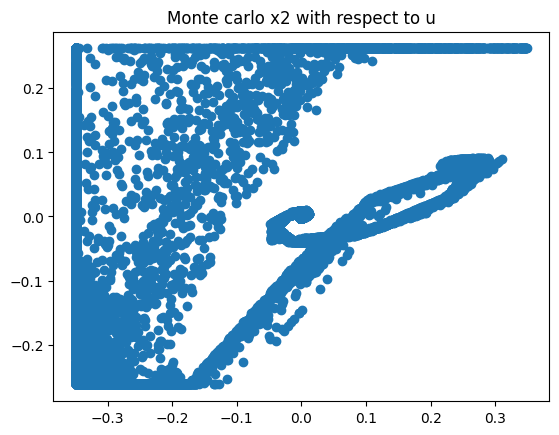

In [9]:
X_data = np.array(X_data)
U_data = np.array(U_data)

x = X_data[:, 1]  
y = U_data[:,0]

plt.title('Monte carlo x2 with respect to u')
plt.scatter(x,y)
plt.show()


## Preparing the dataset

In [10]:
# Initialize lists for inputs and outputs
inputs = []
outputs = []

X_data = np.transpose(X_data, (0, 2, 1))  
U_data = np.transpose(U_data, (0, 2, 1))  

for i in range(num_simulations):
    for t in range(nsim):
        x_t = X_data[i, t, :]  # State at time t
        u_t = U_data[i, t, :]  # Control input at time t
        inputs.append(x_t)
        outputs.append(u_t)

# Convert to arrays
inputs = np.array(inputs)  
outputs = np.array(outputs)  

# Split the data
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)

# Normalize the data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## FeedForwardNN class

In [11]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

## Preparing data

In [12]:
# Define sequence length
seq_length = 5

# Prepare sequential data
def create_sequences(X, y, seq_length):
    X_seq = []
    y_seq = []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length, :])
        y_seq.append(y[i+seq_length, :])
    return np.array(X_seq), np.array(y_seq)

# Create sequences for training and testing data
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

# Convert to PyTorch tensors
X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
X_test_seq_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_seq_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

# Create datasets and dataloaders
train_seq_dataset = TensorDataset(X_train_seq_tensor, y_train_seq_tensor)
test_seq_dataset = TensorDataset(X_test_seq_tensor, y_test_seq_tensor)

train_seq_loader = DataLoader(train_seq_dataset, batch_size=batch_size, shuffle=True)
test_seq_loader = DataLoader(test_seq_dataset, batch_size=batch_size, shuffle=False)

## LSTM and LSTMSNN models

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))  
        out = self.fc(out[:, -1, :])     
        return out

class LSTMSNN(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, nn_hidden_size, output_size, num_layers=5):
        super(LSTMSNN, self).__init__()
        
        # LSTM for past states
        self.hidden_size = lstm_hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, num_layers, batch_first=True)
        
        # FeedforwardNN for current state
        self.feedforward_nn = FeedforwardNN(input_size, nn_hidden_size, nn_hidden_size)
        
        self.w_lstm = nn.Parameter(torch.tensor(0.5))
        self.w_nn = nn.Parameter(torch.tensor(0.5))
        
        self.fc_output = nn.Linear(lstm_hidden_size + nn_hidden_size, output_size)

    def forward(self, x):
        # Separate past states and current state
        past_states = x[:, -5:, :]  
        current_state = x[:, -1, :] 
        
        h0 = torch.zeros(self.num_layers, x.size(0),  self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0),  self.hidden_size, device=x.device)
        out_lstm, _ = self.lstm(past_states, (h0, c0))
        lstm_out = out_lstm[:, -1, :]  
        
        nn_out = self.feedforward_nn(current_state)
        
        # Combine LSTM and FeedforwardNN outputs
        w_sum = self.w_lstm.abs() + self.w_nn.abs()
        lstm_contribution = (self.w_lstm.abs() / w_sum) * lstm_out
        nn_contribution = (self.w_nn.abs() / w_sum) * nn_out
        
        combined = torch.cat((lstm_contribution, nn_contribution), dim=1)
        out = self.fc_output(combined)
        
        return out
    

## Training models

In [14]:
# Set input and output sizes
input_size = X_train_scaled.shape[1]
output_size = y_train_scaled.shape[1]
hidden_size = 10

# Instantiate models
model_NN = FeedforwardNN(input_size, hidden_size, output_size)
model_LSTM = LSTMModel(input_size, hidden_size, output_size)
input_size = X_train_seq.shape[2]  
lstm_hidden_size = 36
nn_hidden_size = 16
output_size = y_train_seq.shape[1]     
model_LSTMSNN = LSTMSNN(input_size, lstm_hidden_size, nn_hidden_size, output_size)

# Define loss function and optimizers
criterion = nn.MSELoss()
optimizer_NN = optim.Adam(model_NN.parameters(), lr=0.001)
optimizer_LSTM = optim.Adam(model_LSTM.parameters(), lr=0.001)
optimizer_LSTMSNN = optim.Adam(model_LSTMSNN.parameters(), lr=1.8908933012414096e-05)

def train_model(model, optimizer, train_loader, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

def train_modelLSTMNN(model, optimizer, train_loader, num_epochs=200):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

print("Training NN-only Model")
train_model(model_NN, optimizer_NN, train_loader)

print("Training LSTM-only Model")
train_model(model_LSTM, optimizer_LSTM, train_seq_loader)

print("Training LSTMSNN Model")
train_modelLSTMNN(model_LSTMSNN, optimizer_LSTMSNN, train_seq_loader)

def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.extend(outputs.numpy())
            actuals.extend(targets.numpy())
    predictions = scaler_y.inverse_transform(np.array(predictions))
    actuals = scaler_y.inverse_transform(np.array(actuals))
    mse = np.mean((predictions - actuals) ** 2)
    return mse, predictions, actuals

mse_NN, pred_NN, actual_NN = evaluate_model(model_NN, test_loader)
mse_LSTM, pred_LSTM, actual_LSTM = evaluate_model(model_LSTM, test_seq_loader)
mse_LSTMSNN, pred_LSTMSNN, actual_LSTMSNN = evaluate_model(model_LSTMSNN, test_seq_loader)

print(f"NN-only Model MSE: {mse_NN:.4f}")
print(f"LSTM-only Model MSE: {mse_LSTM:.4f}")
print(f"LSTMSNN Model MSE: {mse_LSTMSNN:.4f}")

Training NN-only Model
Epoch [5/100], Loss: 0.0147
Epoch [10/100], Loss: 0.0037
Epoch [15/100], Loss: 0.0020
Epoch [20/100], Loss: 0.0013
Epoch [25/100], Loss: 0.0009
Epoch [30/100], Loss: 0.0009
Epoch [35/100], Loss: 0.0007
Epoch [40/100], Loss: 0.0007
Epoch [45/100], Loss: 0.0006
Epoch [50/100], Loss: 0.0006
Epoch [55/100], Loss: 0.0006
Epoch [60/100], Loss: 0.0005
Epoch [65/100], Loss: 0.0005
Epoch [70/100], Loss: 0.0005
Epoch [75/100], Loss: 0.0005
Epoch [80/100], Loss: 0.0005
Epoch [85/100], Loss: 0.0005
Epoch [90/100], Loss: 0.0005
Epoch [95/100], Loss: 0.0005
Epoch [100/100], Loss: 0.0005
Training LSTM-only Model
Epoch [5/100], Loss: 1.0002
Epoch [10/100], Loss: 0.9999
Epoch [15/100], Loss: 0.9997
Epoch [20/100], Loss: 0.9995
Epoch [25/100], Loss: 0.9989
Epoch [30/100], Loss: 0.9990
Epoch [35/100], Loss: 0.9986
Epoch [40/100], Loss: 0.9980
Epoch [45/100], Loss: 0.9978
Epoch [50/100], Loss: 0.9967
Epoch [55/100], Loss: 0.9946
Epoch [60/100], Loss: 0.9932
Epoch [65/100], Loss: 0.9

## Simulating controller with NN 

In [ ]:
def simulate_controller(model, x0, nsim):
    x = np.zeros((n, nsim + 1))
    x[:, 0] = x0
    u = np.zeros((m, nsim))

    iteration_times = []

    for k in range(nsim):
        start_it = time.time_ns()

        # Prepare input
        x_input = x[:, k].reshape(1, -1)
        x_input_scaled = scaler_X.transform(x_input)
        x_input_tensor = torch.tensor(x_input_scaled, dtype=torch.float32)

        # Predict control action
        with torch.no_grad():
            u_pred = model(x_input_tensor).numpy()
        u_unscaled = scaler_y.inverse_transform(u_pred)
        u[:, k] = u_unscaled

        # Apply control action
        x_next = ffunc(x[:, k], u[:, k])
        x[:, k + 1] = x_next

        end_it = time.time_ns()
        iteration_times.append(end_it - start_it)
    return x, u, iteration_times

def simulate_controllerLSTM(model, x0, nsim, seq_length=5):
    x = np.zeros((n, nsim + 1))
    x[:, 0] = x0
    u = np.zeros((m, nsim))
    
    # Initialize a buffer to hold the sequence of past states
    state_buffer = np.zeros((seq_length, n))
    state_buffer[-1] = x0  # Initialize with the first state
    
    for k in range(nsim):
        # Prepare input sequence for the model
        x_input = state_buffer.reshape(1, seq_length, -1)  # (batch_size=1, sequence_length, input_size)
        x_input_scaled = scaler_X.transform(x_input.reshape(-1, n)).reshape(1, seq_length, -1)
        x_input_tensor = torch.tensor(x_input_scaled, dtype=torch.float32)
        
        # Initialize hidden states (h0 and c0) with proper dimensions
        batch_size = x_input_tensor.size(0)
        h0 = torch.zeros(model.num_layers, batch_size, model.hidden_size, device=x_input_tensor.device)
        c0 = torch.zeros(model.num_layers, batch_size, model.hidden_size, device=x_input_tensor.device)
        
        # Predict control action
        with torch.no_grad():
            u_pred = model(x_input_tensor).numpy()
        u_unscaled = scaler_y.inverse_transform(u_pred)
        u[:, k] = u_unscaled
        
        # Apply control action
        x_next = ffunc(x[:, k], u[:, k])
        x[:, k + 1] = x_next
        
        # Update state buffer
        state_buffer = np.roll(state_buffer, shift=-1, axis=0)
        state_buffer[-1] = x_next
    
    return x, u

NN_per_iteration_times = []

x0_test = np.array([0,0.0, 0, 100])
nsim_test = 40

# Simulate controllers
#x_nn, u_nn = simulate_controller(model_NN, x0_test, nsim_test)
x_lstm, u_lstm = simulate_controllerLSTM(model_LSTM,x0_test,nsim_test)
x_lstmsnn, u_lstmsnn = simulate_controllerLSTM(model_LSTMSNN,x0_test,nsim_test)

for idx in range(num_simulations):
    x0 = x0_samples[idx, :]

    x_nn, u_nn, iteration_times = simulate_controller(model_NN, x0_test, nsim)

    NN_per_iteration_times.append(iteration_times)

all_times_nn = np.concatenate(NN_per_iteration_times)
avg_nn_time_ns = np.mean(all_times_nn)
max_nn_time_ns = np.max(all_times_nn)
min_nn_time_ns = np.min(all_times_nn)

print(f"[NN-MPC] Average iteration time [ns]: {avg_nn_time_ns:.2f}")
print(f"[NN-MPC] Max iteration time [ns]: {max_nn_time_ns}")
print(f"[NN-MPC] Min iteration time [ns]: {min_nn_time_ns}")





[NN-MPC] Average iteration time [ns]: 54196.85
[NN-MPC] Max iteration time [ns]: 1856000
[NN-MPC] Min iteration time [ns]: 48000


## Plot results of FeedforwardNN

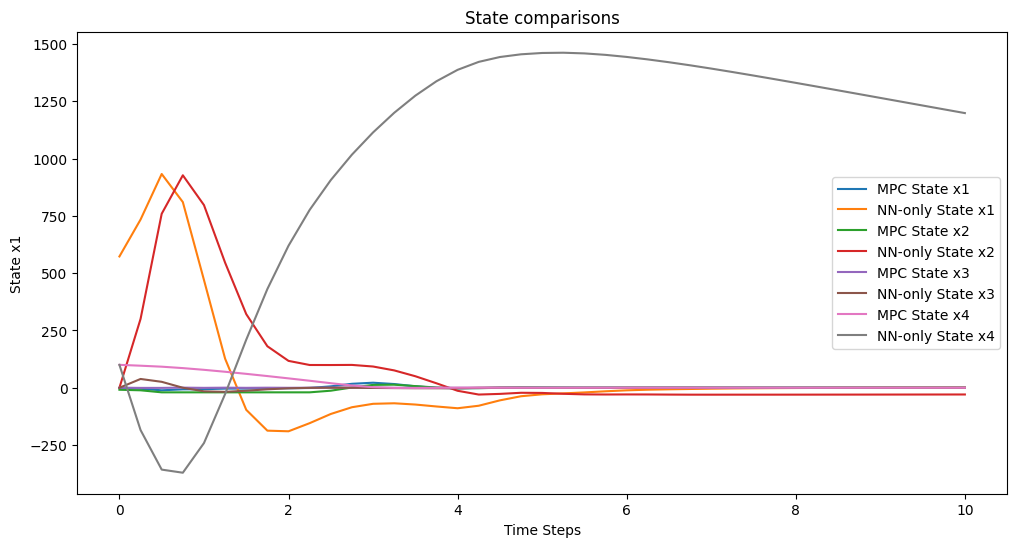

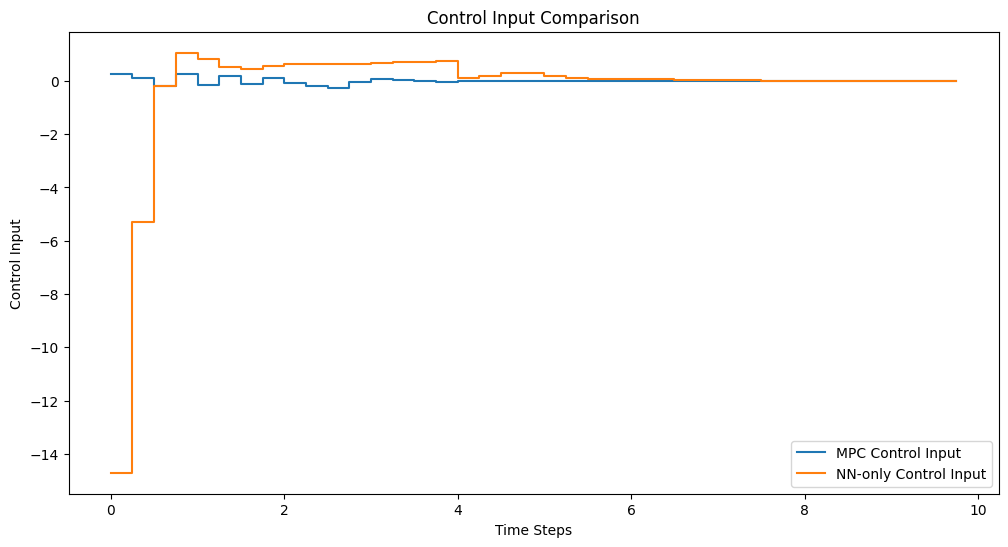

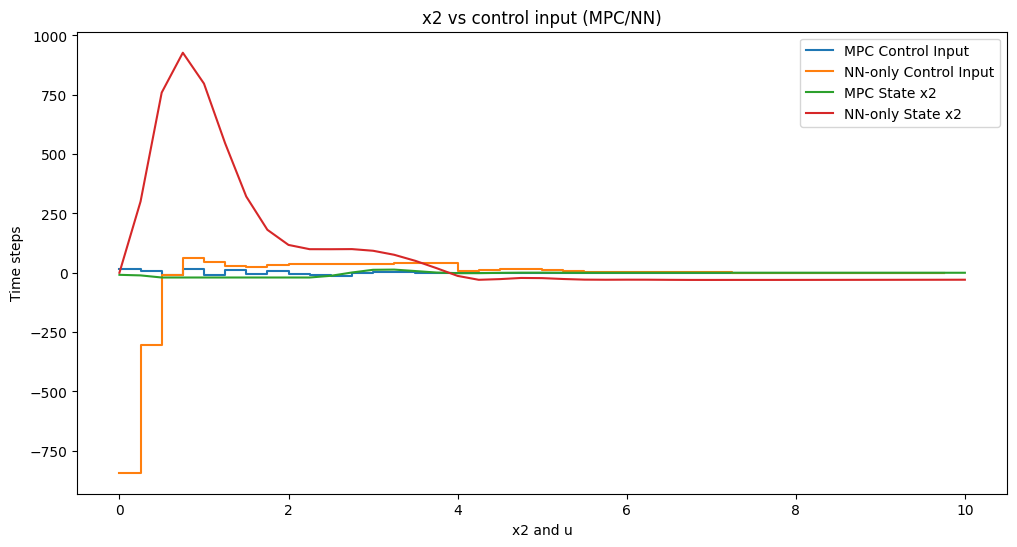

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[0, :]), label='MPC State x1')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_nn[0, :]), label='NN-only State x1')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[1, :]), label='MPC State x2')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_nn[1, :]), label='NN-only State x2')
plt.plot(np.arange(nsim_test + 1) * dt, xcl[2, :], label='MPC State x3')
plt.plot(np.arange(nsim_test + 1) * dt, x_nn[2, :], label='NN-only State x3')
plt.plot(np.arange(nsim_test + 1) * dt, xcl[3, :], label='MPC State x4')
plt.plot(np.arange(nsim_test + 1) * dt, x_nn[3, :], label='NN-only State x4')
plt.title('State comparisons')
plt.xlabel('Time Steps')
plt.ylabel('State x1')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.step(np.arange(nsim_test) * dt , ucl[0, :], where='post', label='MPC Control Input')
plt.step(np.arange(nsim_test) * dt , u_nn[0, :], where='post', label='NN-only Control Input')
plt.title('Control Input Comparison')
plt.xlabel('Time Steps')
plt.ylabel('Control Input')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.step(np.arange(nsim_test) * dt , np.degrees(ucl[0, :]), where='post', label='MPC Control Input')
plt.step(np.arange(nsim_test) * dt , np.degrees(u_nn[0, :]), where='post', label='NN-only Control Input')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[1, :]), label='MPC State x2')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_nn[1, :]), label='NN-only State x2')
plt.title('x2 vs control input (MPC/NN)')
plt.xlabel('x2 and u')
plt.ylabel('Time steps')
plt.legend()
plt.show()

## Plot results of LSTM

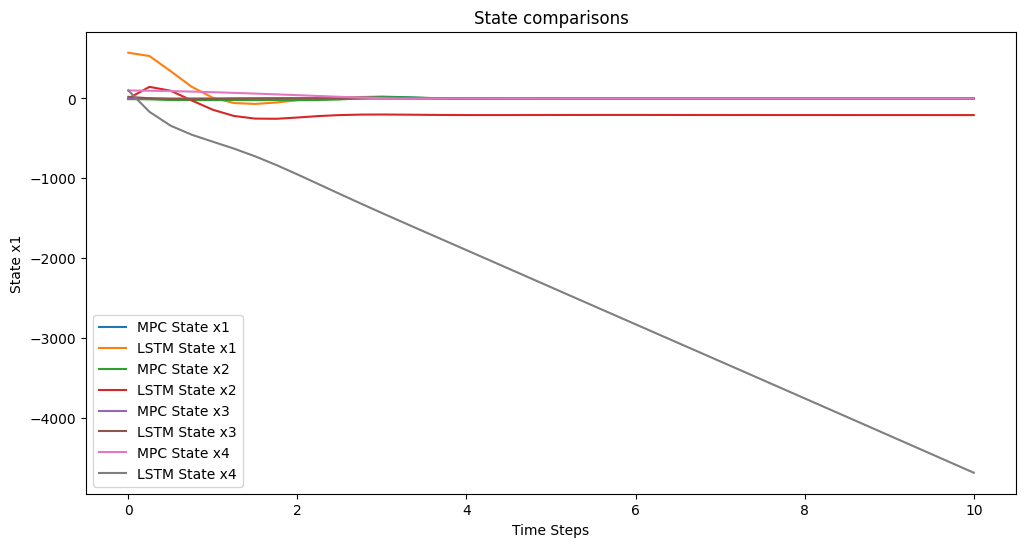

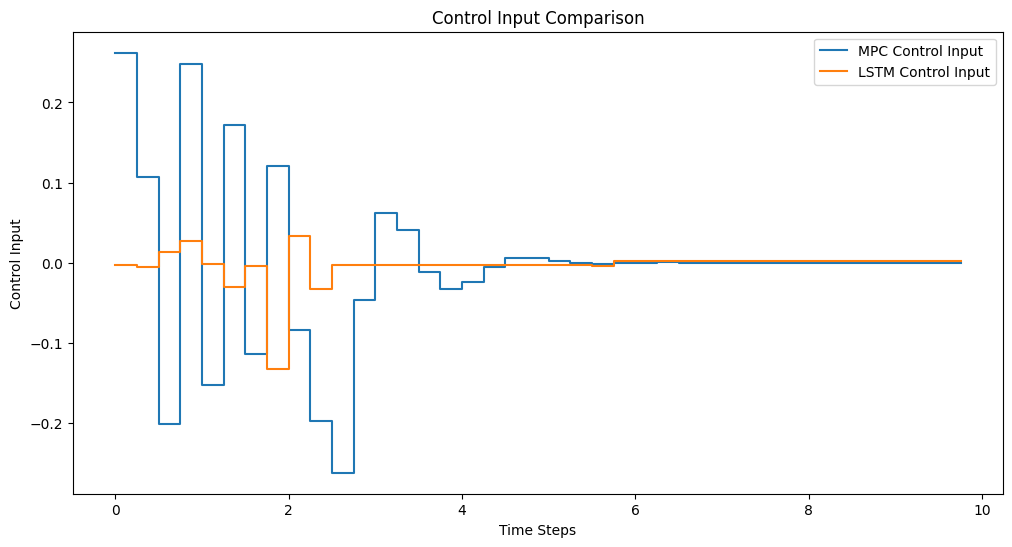

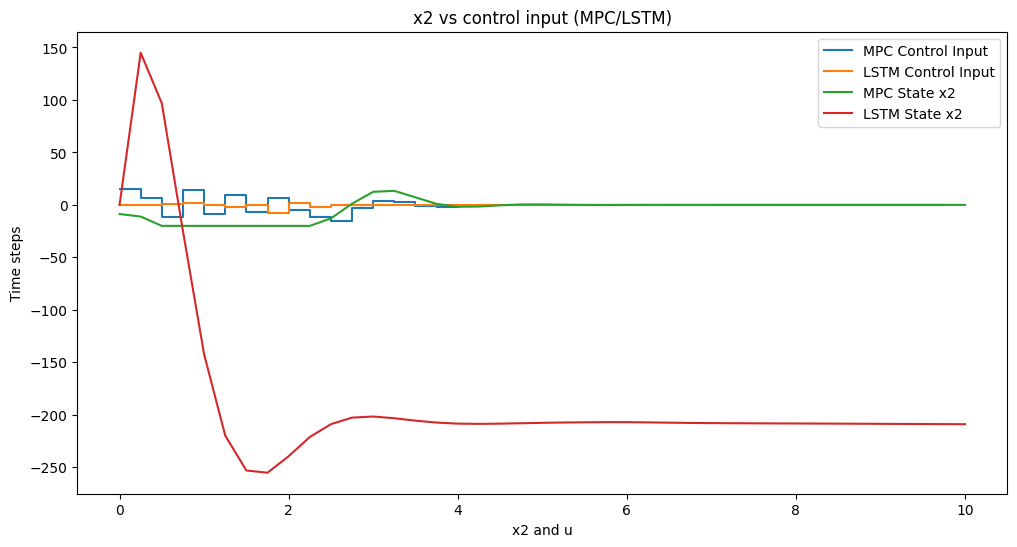

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[0, :]), label='MPC State x1')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_lstm[0, :]), label='LSTM State x1')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[1, :]), label='MPC State x2')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_lstm[1, :]), label='LSTM State x2')
plt.plot(np.arange(nsim_test + 1) * dt, xcl[2, :], label='MPC State x3')
plt.plot(np.arange(nsim_test + 1) * dt, x_lstm[2, :], label='LSTM State x3')
plt.plot(np.arange(nsim_test + 1) * dt, xcl[3, :], label='MPC State x4')
plt.plot(np.arange(nsim_test + 1) * dt, x_lstm[3, :], label='LSTM State x4')
plt.title('State comparisons')
plt.xlabel('Time Steps')
plt.ylabel('State x1')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.step(np.arange(nsim_test) * dt , ucl[0, :], where='post', label='MPC Control Input')
plt.step(np.arange(nsim_test) * dt , u_lstm[0, :], where='post', label='LSTM Control Input')
plt.title('Control Input Comparison')
plt.xlabel('Time Steps')
plt.ylabel('Control Input')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.step(np.arange(nsim_test) * dt , np.degrees(ucl[0, :]), where='post', label='MPC Control Input')
plt.step(np.arange(nsim_test) * dt , np.degrees(u_lstm[0, :]), where='post', label='LSTM Control Input')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[1, :]), label='MPC State x2')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_lstm[1, :]), label='LSTM State x2')
plt.title('x2 vs control input (MPC/LSTM)')
plt.xlabel('x2 and u')
plt.ylabel('Time steps')
plt.legend()
plt.show()

## Plot results of LSTMSNN

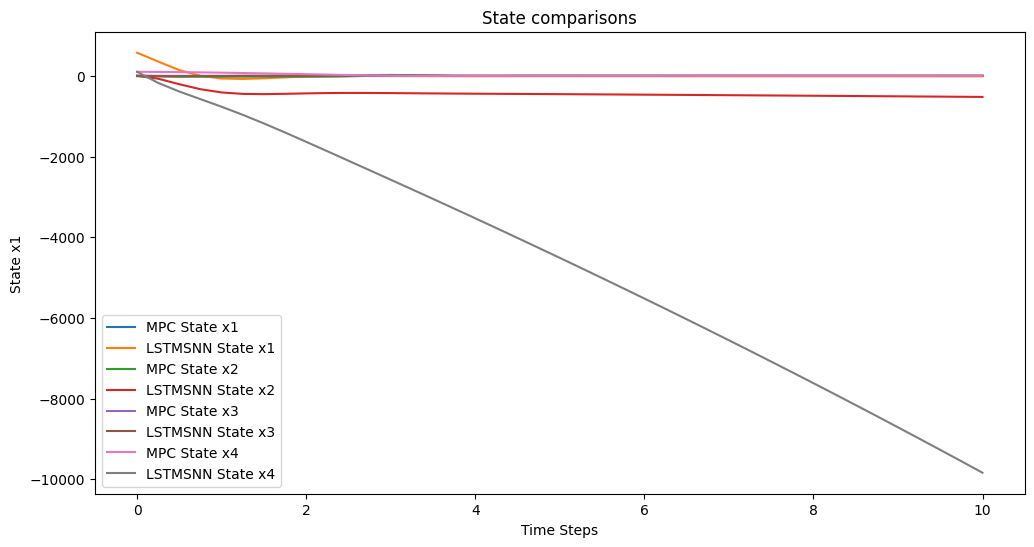

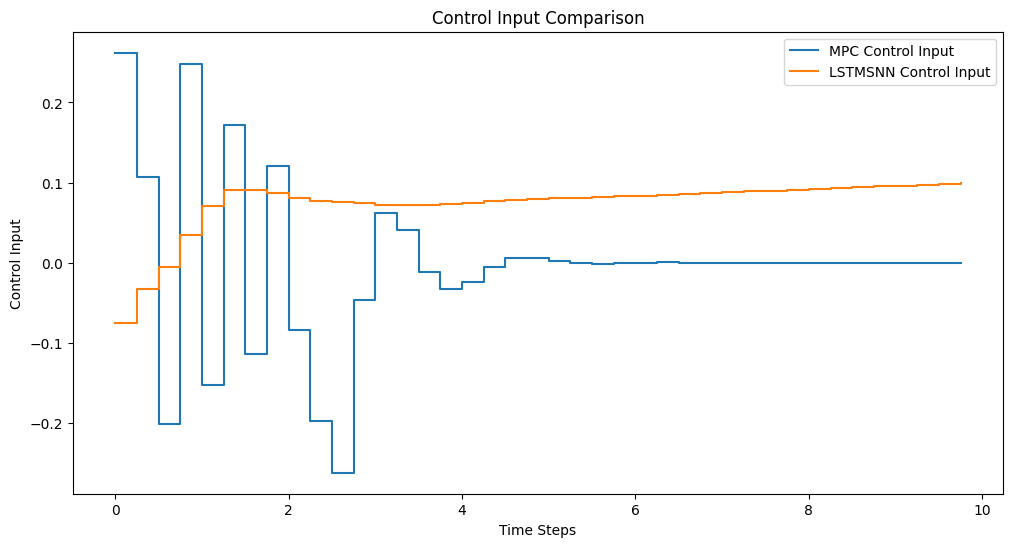

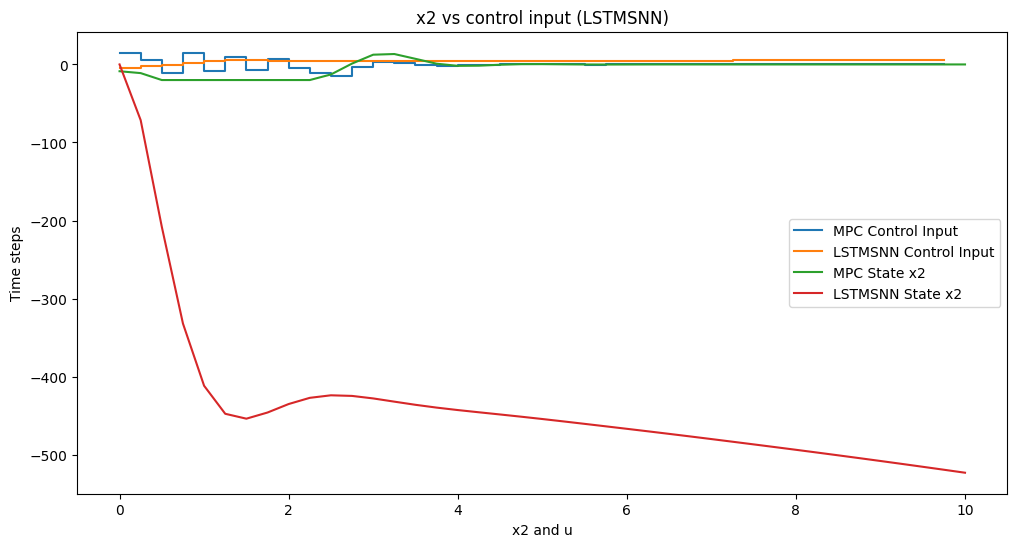

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[0, :]), label='MPC State x1')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_lstmsnn[0, :]), label='LSTMSNN State x1')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[1, :]), label='MPC State x2')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_lstmsnn[1, :]), label='LSTMSNN State x2')
plt.plot(np.arange(nsim_test + 1) * dt, xcl[2, :], label='MPC State x3')
plt.plot(np.arange(nsim_test + 1) * dt, x_lstmsnn[2, :], label='LSTMSNN State x3')
plt.plot(np.arange(nsim_test + 1) * dt, xcl[3, :], label='MPC State x4')
plt.plot(np.arange(nsim_test + 1) * dt, x_lstmsnn[3, :], label='LSTMSNN State x4')
plt.title('State comparisons')
plt.xlabel('Time Steps')
plt.ylabel('State x1')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.step(np.arange(nsim_test) * dt , ucl[0, :], where='post', label='MPC Control Input')
plt.step(np.arange(nsim_test) * dt , u_lstmsnn[0, :], where='post', label='LSTMSNN Control Input')
plt.title('Control Input Comparison')
plt.xlabel('Time Steps')
plt.ylabel('Control Input')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.step(np.arange(nsim_test) * dt , np.degrees(ucl[0, :]), where='post', label='MPC Control Input')
plt.step(np.arange(nsim_test) * dt , np.degrees(u_lstmsnn[0, :]), where='post', label='LSTMSNN Control Input')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(xcl[1, :]), label='MPC State x2')
plt.plot(np.arange(nsim_test + 1) * dt, np.degrees(x_lstmsnn[1, :]), label='LSTMSNN State x2')
plt.title('x2 vs control input (LSTMSNN)')
plt.xlabel('x2 and u')
plt.ylabel('Time steps')
plt.legend()
plt.show()

## Computation time MPC vs NNMPC

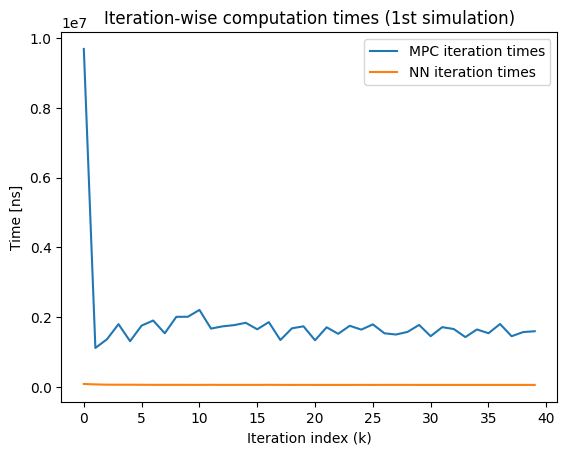

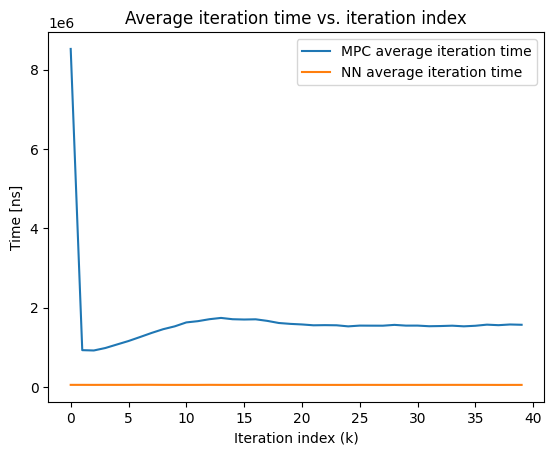

In [27]:
plt.figure()
plt.plot(MPC_per_iteration_times[0], label='MPC iteration times')
plt.plot(NN_per_iteration_times[0], label='NN iteration times')
plt.xlabel('Iteration index (k)')
plt.ylabel('Time [ns]')
plt.title('Iteration-wise computation times (1st simulation)')
plt.legend()
plt.show()

transposed_MPC = zip(*MPC_per_iteration_times)
transposed_NN = zip(*NN_per_iteration_times)

# Compute the mean for each iteration index
avg_iteration_time_MPC = [sum(times) / len(times) for times in transposed_MPC]
avg_iteration_time_NN = [sum(times) / len(times) for times in transposed_NN]

plt.figure()
plt.plot(avg_iteration_time_MPC, label='MPC average iteration time')
plt.plot(avg_iteration_time_NN, label='NN average iteration time')
plt.xlabel('Iteration index (k)')
plt.ylabel('Time [ns]')
plt.title('Average iteration time vs. iteration index')
plt.legend()
plt.show()


